### Get Christian's data

In [1]:
import glob
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
SM_SIZE = 10
MD_SIZE = 12
LG_SIZE = 16

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

In [3]:
A_100K_dir = '/blue/adamginsburg/abulatek/brick/dasar/henkel_methanol_A_100K/'
A_100K_files = glob.glob(f'{A_100K_dir}/*')

In [4]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

In [5]:
tbl_rows = []

temp_K = 100
for fn in A_100K_files:
    # Access physical parameters
    with open(fn) as f:
        i = 0
        for line in nonblank_lines(f):
            if i == 0:
                i += 1
                continue
            elif i == 1:
                params = line
                i += 1
            else:
                break
    dens = float(params.split('n(H_2)=')[1].split('(cm-3)')[0])
    # print(f'{dens:.0e}')
    coldens = float(params.split('N(CH3OH)=')[1].split('(cm-2)')[0])
    # print(f'{coldens:.0e}')
    
    # Access data
    data = ascii.read(fn, data_start = 4, header_start = 3, names = ['Ji', 'Ki', 'Vi', 'Jf', 'Kf', 'Vf', 'freq (GHz)', 'Tex(K)', 'tau', 'Tb(K)']) 
    dasar_ln = np.argmax((data['Ji'] == 3) & (data['Ki'] == 1) & (data['Jf'] == 4) & (data['Kf'] == 0))
    tex = data[dasar_ln]['Tex(K)']
    tau = data[dasar_ln]['tau']
    tb = data[dasar_ln]['Tb(K)']
    
    tbl_rows.append([dens, coldens, tex, tau, tb])
christian_tbl = Table(rows=tbl_rows, names=('dens', 'coldens', 'tex', 'tau', 'tb'))
print(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']))
print(np.max(christian_tbl['coldens']))

1000.0 10000000.0
1e+16


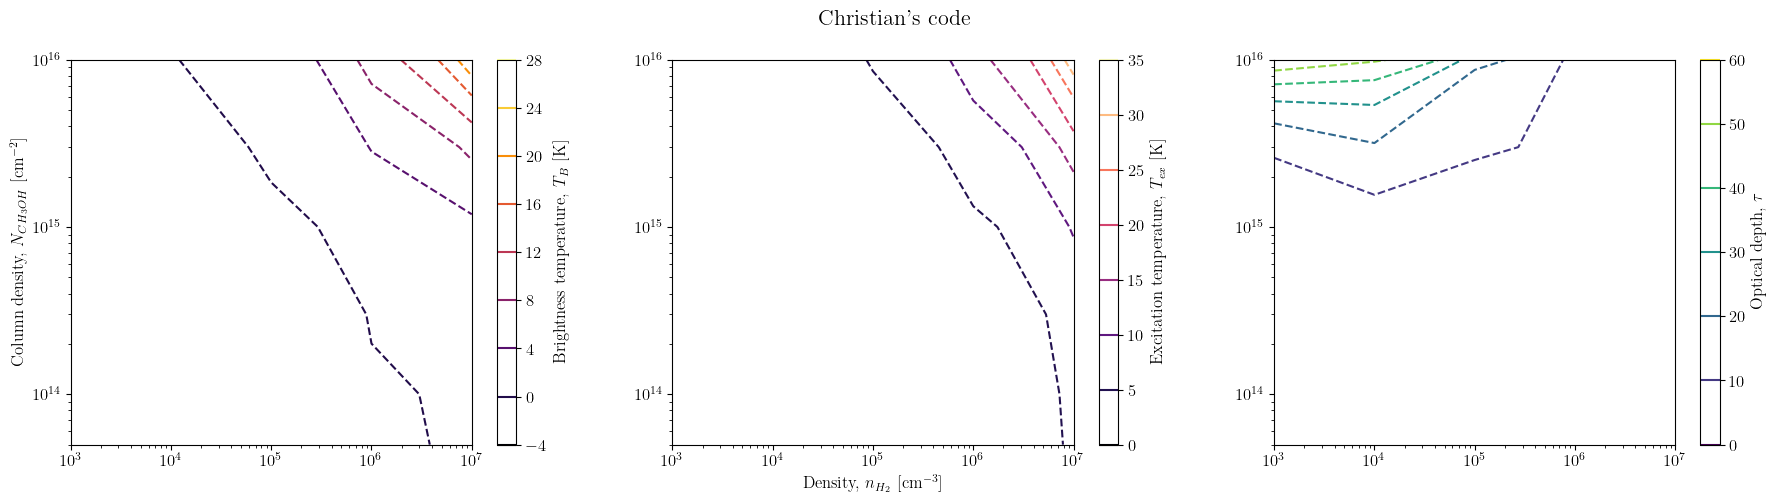

In [6]:
christian_dens, christian_dens_ids = np.unique(christian_tbl['dens'], return_inverse=True)
christian_coldens, christian_coldens_ids = np.unique(christian_tbl['coldens'], return_inverse=True)
christian_dens_grid, christian_coldens_grid = np.meshgrid(christian_dens, christian_coldens)

christian_tb_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tb_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tb']
christian_tex_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tex_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tex']
christian_tau_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tau_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tau']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (22, 5))

cp1 = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = 6, linestyles = '--', cmap = 'inferno', alpha = 1)
ax1.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

cp2 = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = 6, linestyles = '--', cmap = 'magma', alpha = 1)
ax2.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")

cp3 = ax3.contour(christian_dens_grid, christian_coldens_grid, christian_tau_grid, levels = 6, linestyles = '--', cmap = 'viridis', alpha = 1)
plt.colorbar(cp3, ax = ax3, label = r"Optical depth, $\tau$")

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.suptitle("Christian's code")

plt.show()

### Run RADEX for the same situation (100 K)

In [7]:
import pyradex
import os
os.environ['RADEX_DATAPATH'] = '/orange/adamginsburg/repos/pyradex/lamda/'
import matplotlib.pyplot as plt
from astroquery.lamda import Lamda
# import dask
# dask.config.set(scheduler = 'threads', num_workers = 8)
# from dask.diagnostics import ProgressBar
# ProgressBar().register()

In [8]:
ls /orange/adamginsburg/repos/pyradex/lamda/

ch3oh_a.dat  co.dat  e-ch3oh.dat  nacl.dat  ph2co-h2.dat  sio-h2.dat


In [9]:
# Get methanol A species results for given column, density, and temperature
set_column = 1e14
set_density = 1e5
set_temp = 50
rr = pyradex.Radex(species='ch3oh_a', column=set_column, density=set_density, temperature=set_temp)
tbl = rr()

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:1056: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


In [10]:
# Which line is the dasar line?
np.argmax((tbl['upperlevel'] == b'3_1   ') & (tbl['lowerlevel'] == b'4_0   '))

62

In [11]:
tbl[62]

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
1.3046936795972943,0.3458920073168159,107.013831,28.3,3_1,4_0,0.0027329811516297064,0.17991856934978337,-8.458739164652115e-16,-0.24041077989339263


In [12]:
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[62]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

In [13]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

### This is the figure that goes in the paper

-0.819132482178787 is the minimum, it doesn't actually go down to -1


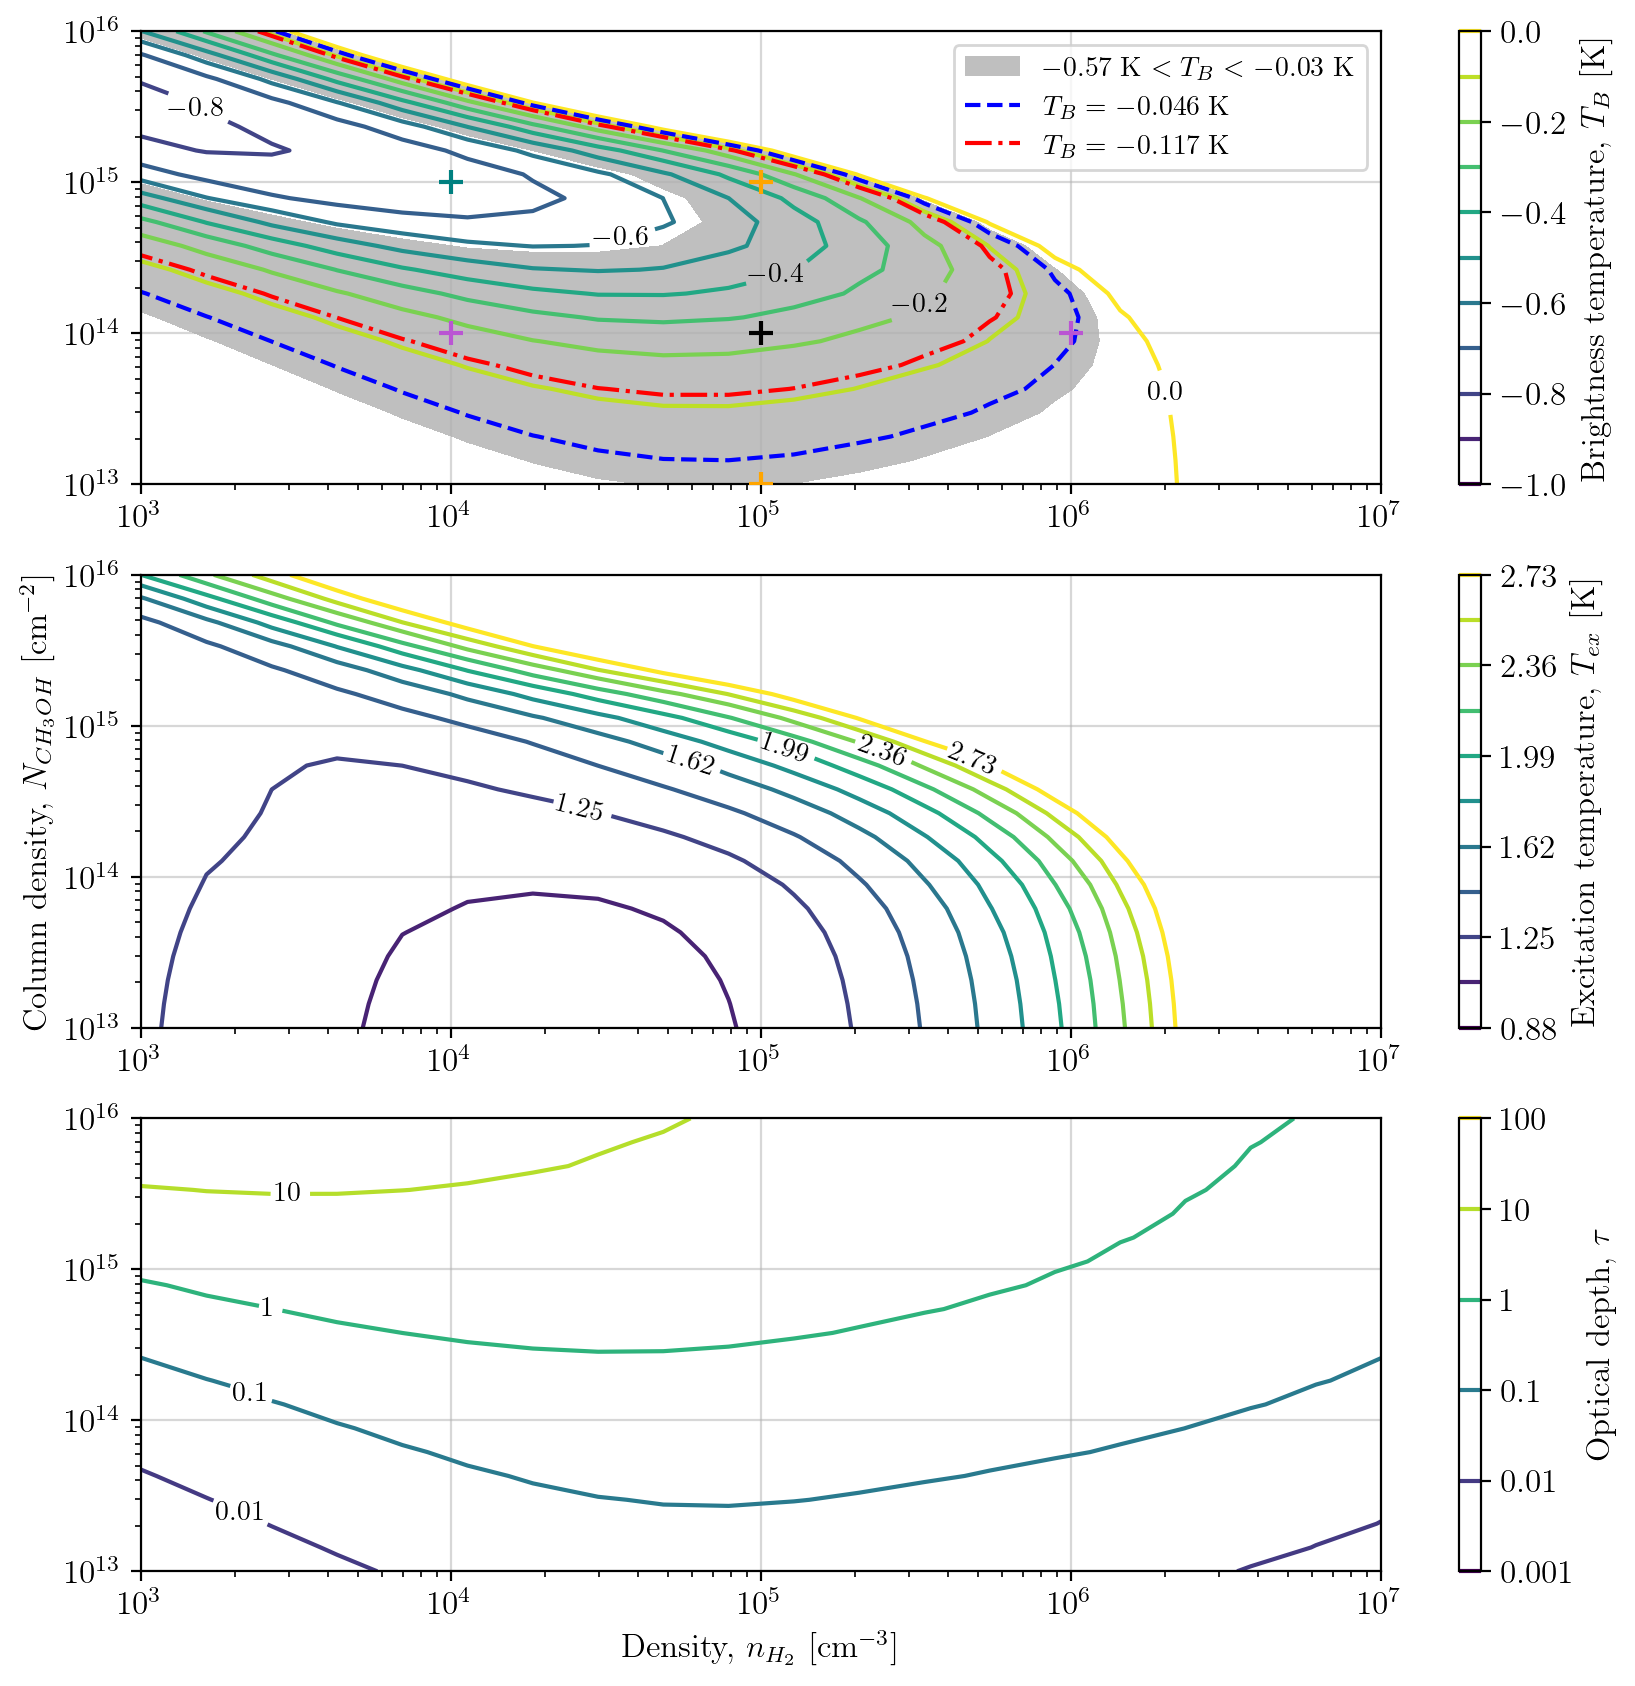

In [106]:
import matplotlib.colors as colors

the_best_colormap = 'viridis'

radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

# radex_tb_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tb_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_T_B)
# radex_tex_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tex_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tex)
# radex_tau_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tau_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tau)

lvl_set = 11 # odd, want smth at middle

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 10), dpi = 200) #24, 8

# Need this early so the contour labels work
for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

### Brightness temperature plot
cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")
cpl1_locs = [(1.5e3, 3e15), (3.5e4, 4.7e14), (1.1e5, 2.8e14), (3e5, 2e14), (2e6, 4e13)]
cpl1 = ax1.clabel(CS = cp1, inline = 1, fontsize=10, manual = cpl1_locs, colors = 'k')
for l in cpl1:
    l.set_rotation(0)

# Shading where T_B goes below 0, and where it goes below our data value (-0.03 K is placeholder for now)
darkest_spectrum = -0.57
least_dark_spectrum_detectable = -0.03 # This is negative 1 sigma
# radex_T_B_arr = np.array(radex_T_B)
# [c, d] = np.where((radex_T_B_arr > darkest_spectrum) & (radex_T_B_arr < least_dark_spectrum_detectable))

# radex_T_B_arr_hatch = np.zeros(radex_T_B_arr.shape)
# radex_T_B_arr_hatch[c, d] = 1

# Putting contours at the points where the minimum values of spectral extractions are
# So, that is at -0.046 K and -0.117 K
minimum_of_cavity_wall_meanspec = -0.046
minimum_of_cavity_wall_meanspec_5sigma = -0.117

cs1 = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [darkest_spectrum, least_dark_spectrum_detectable],
                   alpha = 0.5, colors = ['grey'])
cs1a = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec], alpha = 1, colors = ['b'])
cs1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec_5sigma], alpha = 1, colors = ['r'], linestyles = ['-.'])
artists1, labels1 = cs1.legend_elements()
artists1a, labels1a = cs1a.legend_elements()
artists1b, labels1b = cs1b.legend_elements()
ax1.legend(fontsize = 10, handles = [artists1[0], artists1a[0], artists1b[0]], 
           labels = [f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K', 
                     f'$T_B = {minimum_of_cavity_wall_meanspec}$ K',
                     f'$T_B = {minimum_of_cavity_wall_meanspec_5sigma}$ K'], loc="upper right")

# Put crosses where we sampled for the temperature figure
temp_marker_size = 80
ax1.scatter(1e5, 1e14, marker = "+", c='k', s=temp_marker_size, zorder = 100)
ax1.scatter(1e5, 1e15, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
ax1.scatter(1e5, 1e13, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
ax1.scatter(1e4, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
ax1.scatter(1e6, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
ax1.scatter(1e4, 1e15, marker = "+", c='teal', s=temp_marker_size, zorder = 100)

### Excitation temperature plot
cp2 = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, 
                  levels = np.around(np.linspace(np.min(radex_tex)*0.9, 2.73, 11), decimals = 2), 
                  cmap = the_best_colormap, alpha = 1) #magma
ax2.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")
cpl2_locs = [(2.5e4, 2e14), (6e4, 6e14), (1.2e5, 7.2e14), (2.5e5, 7.2e14), (5e5, 7.2e14)]
cpl2 = ax2.clabel(CS = cp2, inline = 1, fontsize=10, manual = cpl2_locs, colors = 'k')

# Shading where T_ex goes below 2
# radex_tex_arr = np.array(radex_tex)
# [m, n] = np.where(radex_tex_arr < 2.0)

# radex_tex_arr_hatch = np.zeros(radex_tex_arr.shape)
# radex_tex_arr_hatch[m, n] = 1
# cs2 = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex, levels = [0, 2], alpha = 0.5, colors = ['grey'])
# artists2, labels2 = cs2.legend_elements()
# ax2.legend(handles = [artists2[0]], labels = ['$T_{ex} < 2$ K'], loc="lower left")

### Optical depth plot
cp3 = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, levels = lvl_set, cmap = the_best_colormap, alpha = 1, #viridis
                  norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max()))
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
cb3 = plt.colorbar(cp3, ax = ax3, extend = 'max', label = r"Optical depth, $\tau$")
cb3.set_ticklabels([f'{x:0.1g}' if x % 1 > 0 else int(x) for x in cb3.get_ticks()])
cpl3_locs = [(3e3, 3.5e15), (2.6e3, 6e14), (2.25e3, 1.5e14), (2e3, 2e13)]
cpl3 = ax3.clabel(CS = cp3, inline = 1, fontsize=10, manual = cpl3_locs, fmt = '%1g', colors = 'k')
for l in cpl3:
    l.set_rotation(0)

# Make sure plot backgrounds are right for poster
ax1.set(facecolor = "white")
ax2.set(facecolor = "white")
ax3.set(facecolor = "white")
fig.patch.set_alpha(0.0)

ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax3.grid(alpha = 0.5)

plt.savefig('632e0742965a6e88270d73d7/pyradex_results.pdf', bbox_inches = 'tight')
# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### Just grab the first panel of the plot for the PP7 poster

-0.819132482178787 is the minimum, it doesn't actually go down to -1


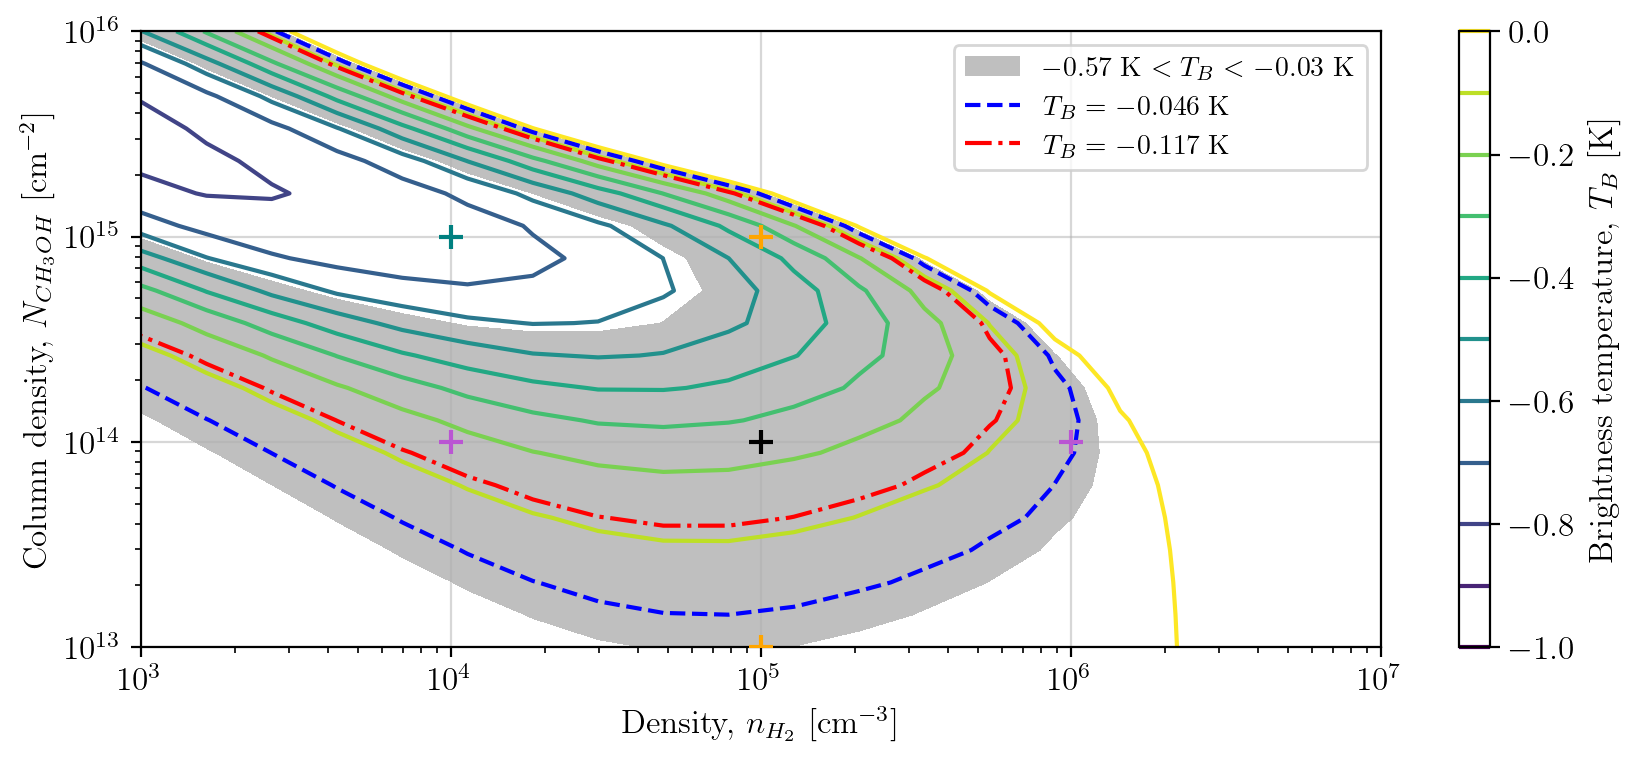

In [15]:
lvl_set = 11 # odd, want smth at middle

fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4), dpi = 200) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

### Brightness temperature plot
cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

# Shading where T_B goes below 0, and where it goes below our data value (-0.03 K is placeholder for now)
darkest_spectrum = -0.57
least_dark_spectrum_detectable = -0.03 # This is negative 1 sigma
# radex_T_B_arr = np.array(radex_T_B)
# [c, d] = np.where((radex_T_B_arr > darkest_spectrum) & (radex_T_B_arr < least_dark_spectrum_detectable))

# radex_T_B_arr_hatch = np.zeros(radex_T_B_arr.shape)
# radex_T_B_arr_hatch[c, d] = 1

# Putting contours at the points where the minimum values of spectral extractions are
# So, that is at -0.046 K and -0.117 K
minimum_of_cavity_wall_meanspec = -0.046
minimum_of_cavity_wall_meanspec_5sigma = -0.117

cs1 = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [darkest_spectrum, least_dark_spectrum_detectable],
                   alpha = 0.5, colors = ['grey'])
cs1a = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec], alpha = 1, colors = ['b'])
cs1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec_5sigma], alpha = 1, colors = ['r'], linestyles = ['-.'])
artists1, labels1 = cs1.legend_elements()
artists1a, labels1a = cs1a.legend_elements()
artists1b, labels1b = cs1b.legend_elements()
ax1.legend(fontsize = 10, handles = [artists1[0], artists1a[0], artists1b[0]], 
           labels = [f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K', 
                     f'$T_B = {minimum_of_cavity_wall_meanspec}$ K',
                     f'$T_B = {minimum_of_cavity_wall_meanspec_5sigma}$ K'], loc="upper right")

# Put a cross where we sampled for the temperature figure
temp_marker_size = 80
ax1.scatter(1e5, 1e14, marker = "+", c='k', s=temp_marker_size, zorder = 100)
ax1.scatter(1e5, 1e15, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
ax1.scatter(1e5, 1e13, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
ax1.scatter(1e4, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
ax1.scatter(1e6, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
ax1.scatter(1e4, 1e15, marker = "+", c='teal', s=temp_marker_size, zorder = 100)

ax1.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
ax1.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")

for ax in [ax1]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.grid(alpha = 0.5)
    
# Make sure plot backgrounds are right for poster
ax1.set(facecolor = "white")
fig.patch.set_alpha(0.0)

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_poster.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### We are doing an experiment about other methanol dasars

In [16]:
test_rslts = rr(density = {'H2':1e5}, column = 1e14, temperature = 100)
test_rslts[test_rslts['upperlevel'] == b'1_1   ']

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population


Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
2.5547471118199714,0.3095684862878898,205.79127,16.8,1_1,2_0,0.0017038550176205311,0.13563204560833828,-2.1376830175481776e-16,-0.016429242498051798
4.35122979469692,0.6182887169608018,350.9051,16.8,1_1,0_0,0.0017038550176205311,0.027239424675343536,5.637797790090158e-15,0.14902470201635107


In [17]:
rr(density = {'H2':1e5}, column = 1e14, temperature = 100)[[62, 70, 114]]

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
1.2344261703186383,0.3454254696619874,107.013831,28.3,3_1,4_0,0.0021727963326694587,0.17896039777406075,-8.663445915219649e-16,-0.24622887034344934
27.49064078663354,0.0022420119466619185,143.865795,28.3,3_1,2_1,0.0021727963326694587,0.0019951287357974357,3.3587384715890933e-16,0.052818883457793384
30.96725553468719,0.2944569337805771,241.791352,34.8,5_0,4_0,0.15037381873168226,0.17896039777406075,1.1617085900255344e-13,6.467609657528522


In [18]:
dasars_maybe = rr(density = {'H2':1e5}, column = 1e14, temperature = 100)
dasars_maybe[dasars_maybe['T_B'] < 0]

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
0.07286956831480143,0.4696976067577284,6.668564,49.1,5_1,6_0,0.0010915649225185548,0.10333428576463706,-1.3113219887215051e-17,-0.9597824933814906
0.09670939700788378,1.910471921083481e-05,7.682289,261.4,12_-4,13_-3,2.757343288826914e-07,1.3446740695596454e-05,-8.798851897218341e-22,-4.852581671070536e-05
0.09120837610696123,2.3548904094186298e-05,7.83089,261.4,12_4,13_3,2.483336119628334e-07,1.6437860427074626e-05,-1.1250787497971436e-21,-5.971573779385462e-05
1.5917575784532119,7.490336888588077e-05,23.120915,142.2,9_2,10_1,3.82726746285483e-05,8.492107861759817e-05,-1.368704527833909e-20,-8.333506860146762e-05
0.8508562061061291,0.0004880770391051118,28.969966,121.3,8_-2,9_-1,5.947605138193515e-05,0.00034045611603385087,-2.2104457179164837e-19,-0.0008572589162903901
0.9513046254421116,6.717168839358265e-11,37.257384,295.3,15_-1,14_-3,9.440799091957603e-07,5.787577345148061e-06,-4.620013195233432e-26,-1.0832947228628395e-10
1.6999046620595268,0.00019811510779603196,38.29327,86.5,6_-2,5_-3,0.00011893113398071686,0.0002966088348698557,-8.666824630094819e-20,-0.0001923726061476112
1.5865876383008106,0.00022002122039396205,38.452629,86.5,6_2,5_3,0.00011695013623383655,0.0003167391279732974,-1.0728259519708345e-19,-0.00023615944668388256


### Overplot Christian's results and RADEX results (appendix figure)

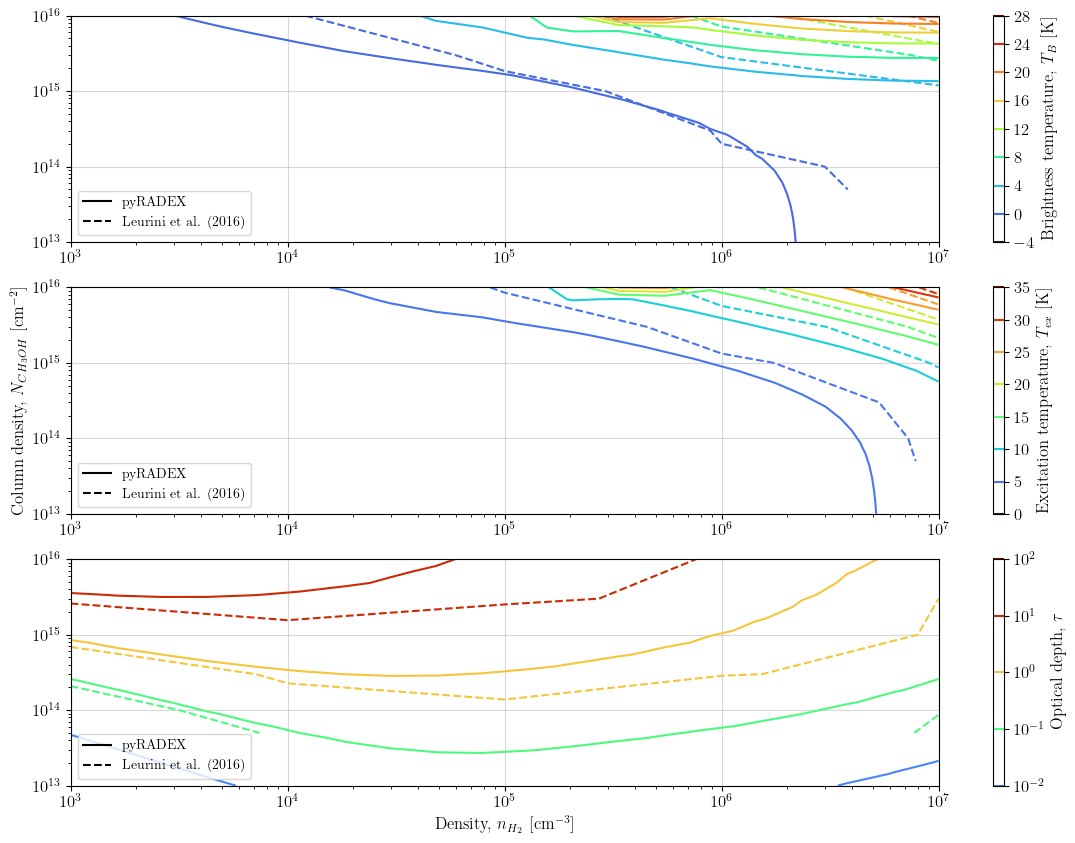

In [19]:
from matplotlib.lines import Line2D

lvl_set = 6

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (14, 10)) #24, 8

# Brightness temperature
cp1a = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo')
cp1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = lvl_set, cmap = 'turbo', alpha = 1) #inferno
plt.colorbar(cp1a, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")
# plt.colorbar(cp1b, ax = ax1)
code_artists = [Line2D([0], [0], color='k'), Line2D([0], [0], color='k', linestyle='--')]
code_labels = ["pyRADEX", "Leurini et al. (2016)"]

# # Shading where T_B goes below 0, and where it goes below our data value (-0.1 K is placeholder for now)
# christian_tb_grid_arr = np.array(christian_tb_grid)
# [e, f] = np.where((christian_tb_grid_arr > darkest_spectrum) & (christian_tb_grid_arr < least_dark_spectrum_detectable))
# christian_tb_grid_arr_hatch = np.zeros(christian_tb_grid_arr.shape)
# christian_tb_grid_arr_hatch[e, f] = 1

# cs1a = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','r']) # hatches=['','//'],
# artists1a, labels1a = cs1a.legend_elements()
# cs1b = ax1.contourf(christian_dens_grid, christian_coldens_grid, christian_tb_grid_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','b']) # hatches=['','//'],
# artists1b, labels1b = cs1b.legend_elements()

ax1.legend(handles = code_artists,#+[artists1a[1], artists1b[1]], 
           labels = code_labels,#+[f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K (pyRADEX)', f"${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K (Christian's code)"], 
           loc="lower left")

# Excitation temperature
cp2a = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo')
cp2b = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, levels = lvl_set, cmap = 'turbo', alpha = 1) #magma
plt.colorbar(cp2a, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")
ax2.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
# plt.colorbar(cp2b, ax = ax2)

# # Shading where T_ex goes below 2
# christian_tex_grid_arr = np.array(christian_tex_grid)
# [o, p] = np.where(christian_tex_grid_arr < 2.0)

# christian_tex_grid_arr_hatch = np.zeros(christian_tex_grid_arr.shape)
# christian_tex_grid_arr_hatch[o, p] = 1

# cs2a = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','r'])
# artists2a, labels2a = cs2a.legend_elements()
# cs2b = ax2.contourf(christian_dens_grid, christian_coldens_grid, christian_tex_grid_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','b'])
# artists2b, labels2b = cs2b.legend_elements()

ax2.legend(handles = code_artists,#+[artists2a[1], artists2b[1]],
           labels = code_labels,#+['$T_{ex} < 2$ K (pyRADEX)', "$T_{ex} < 2$ K (Christian's code)"],
           loc = "lower left")

# Optical depth
cp3a = ax3.contour(christian_dens_grid, christian_coldens_grid, christian_tau_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo', 
                   norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max()))
cp3b = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, levels = lvl_set, cmap = 'turbo', alpha = 1,
                   norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max())) #viridis
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp3a, ax = ax3, label = r"Optical depth, $\tau$")
# plt.colorbar(cp3b, ax = ax3)
ax3.legend(handles = code_artists, labels = code_labels, loc="lower left")

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax3.grid(alpha = 0.5)

# plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison.pdf', bbox_inches = 'tight')
# plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### For symposium 2022 talk (remove the tau, for brevity's sake)

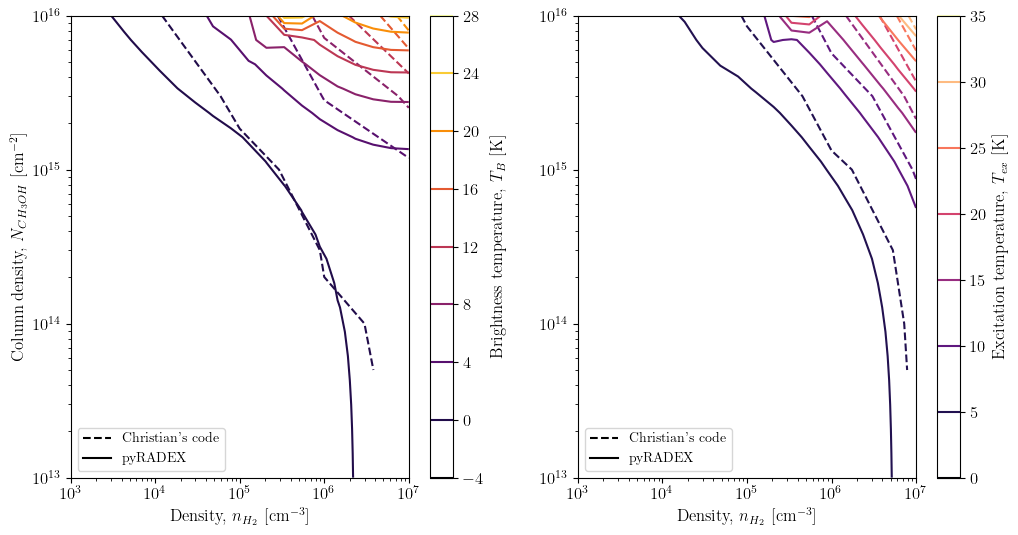

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

cp1a = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = 6, 
                   linestyles = '--', cmap = 'inferno')
cp1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = 6, cmap = 'inferno', alpha = 1)
ax1.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
ax1.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp1a, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")
# plt.colorbar(cp1b, ax = ax1)
legend_elements = [Line2D([0], [0], color='k', linestyle='--', label="Christian's code"),
                   Line2D([0], [0], color='k', label="pyRADEX")]
ax1.legend(handles = legend_elements, loc="lower left")

cp2a = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = 6, 
                   linestyles = '--', cmap = 'magma')
cp2b = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, levels = 6, cmap = 'magma', alpha = 1)
ax2.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp2a, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")
# plt.colorbar(cp2b, ax = ax2)
ax2.legend(handles = legend_elements, loc="lower left")

for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison_notau.pdf', bbox_inches = 'tight')
# plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison_notau.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### Exploration of the 36 GHz E-type line

In [21]:
# Lamda.molecule_dict
os.environ['RADEX_DATAPATH'] = '/orange/adamginsburg/repos/pyradex/lamda/'

In [22]:
# Get methanol E species results for given column, density, and temperature
set_column = 1e14
set_density = 1e5
set_temp = 50
rr = pyradex.Radex(species='e-ch3oh', column=set_column, density=set_density, temperature=set_temp)
tbl = rr()

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:1056: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


In [23]:
# Which line is the 36 GHz line?
np.argmax((tbl['upperlevel'] == b'4_-1  ') & (tbl['lowerlevel'] == b'3_0   '))

35

In [24]:
tbl[35]

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
-0.818688147458583,-0.5022639619952196,36.169261,28.8,4_-1,3_0,0.17380690228235995,0.016235154642032668,1.0290559000384283e-15,2.560282121725862


In [25]:
# Quickly explore as a function of temperature
temps = np.linspace(2.73, 200, 300)
rslts3 = [rr(temperature=temp, density={'H2':set_density}, column=set_column)[35]['Tex', 'tau', 'T_B'] for temp in temps]

Text(0.5, 0.94, '$N_{CH_3 OH}$ = 1e+14 cm$^{-2}$, $n_{H_2}$ = 1e+05 cm$^{-3}$')

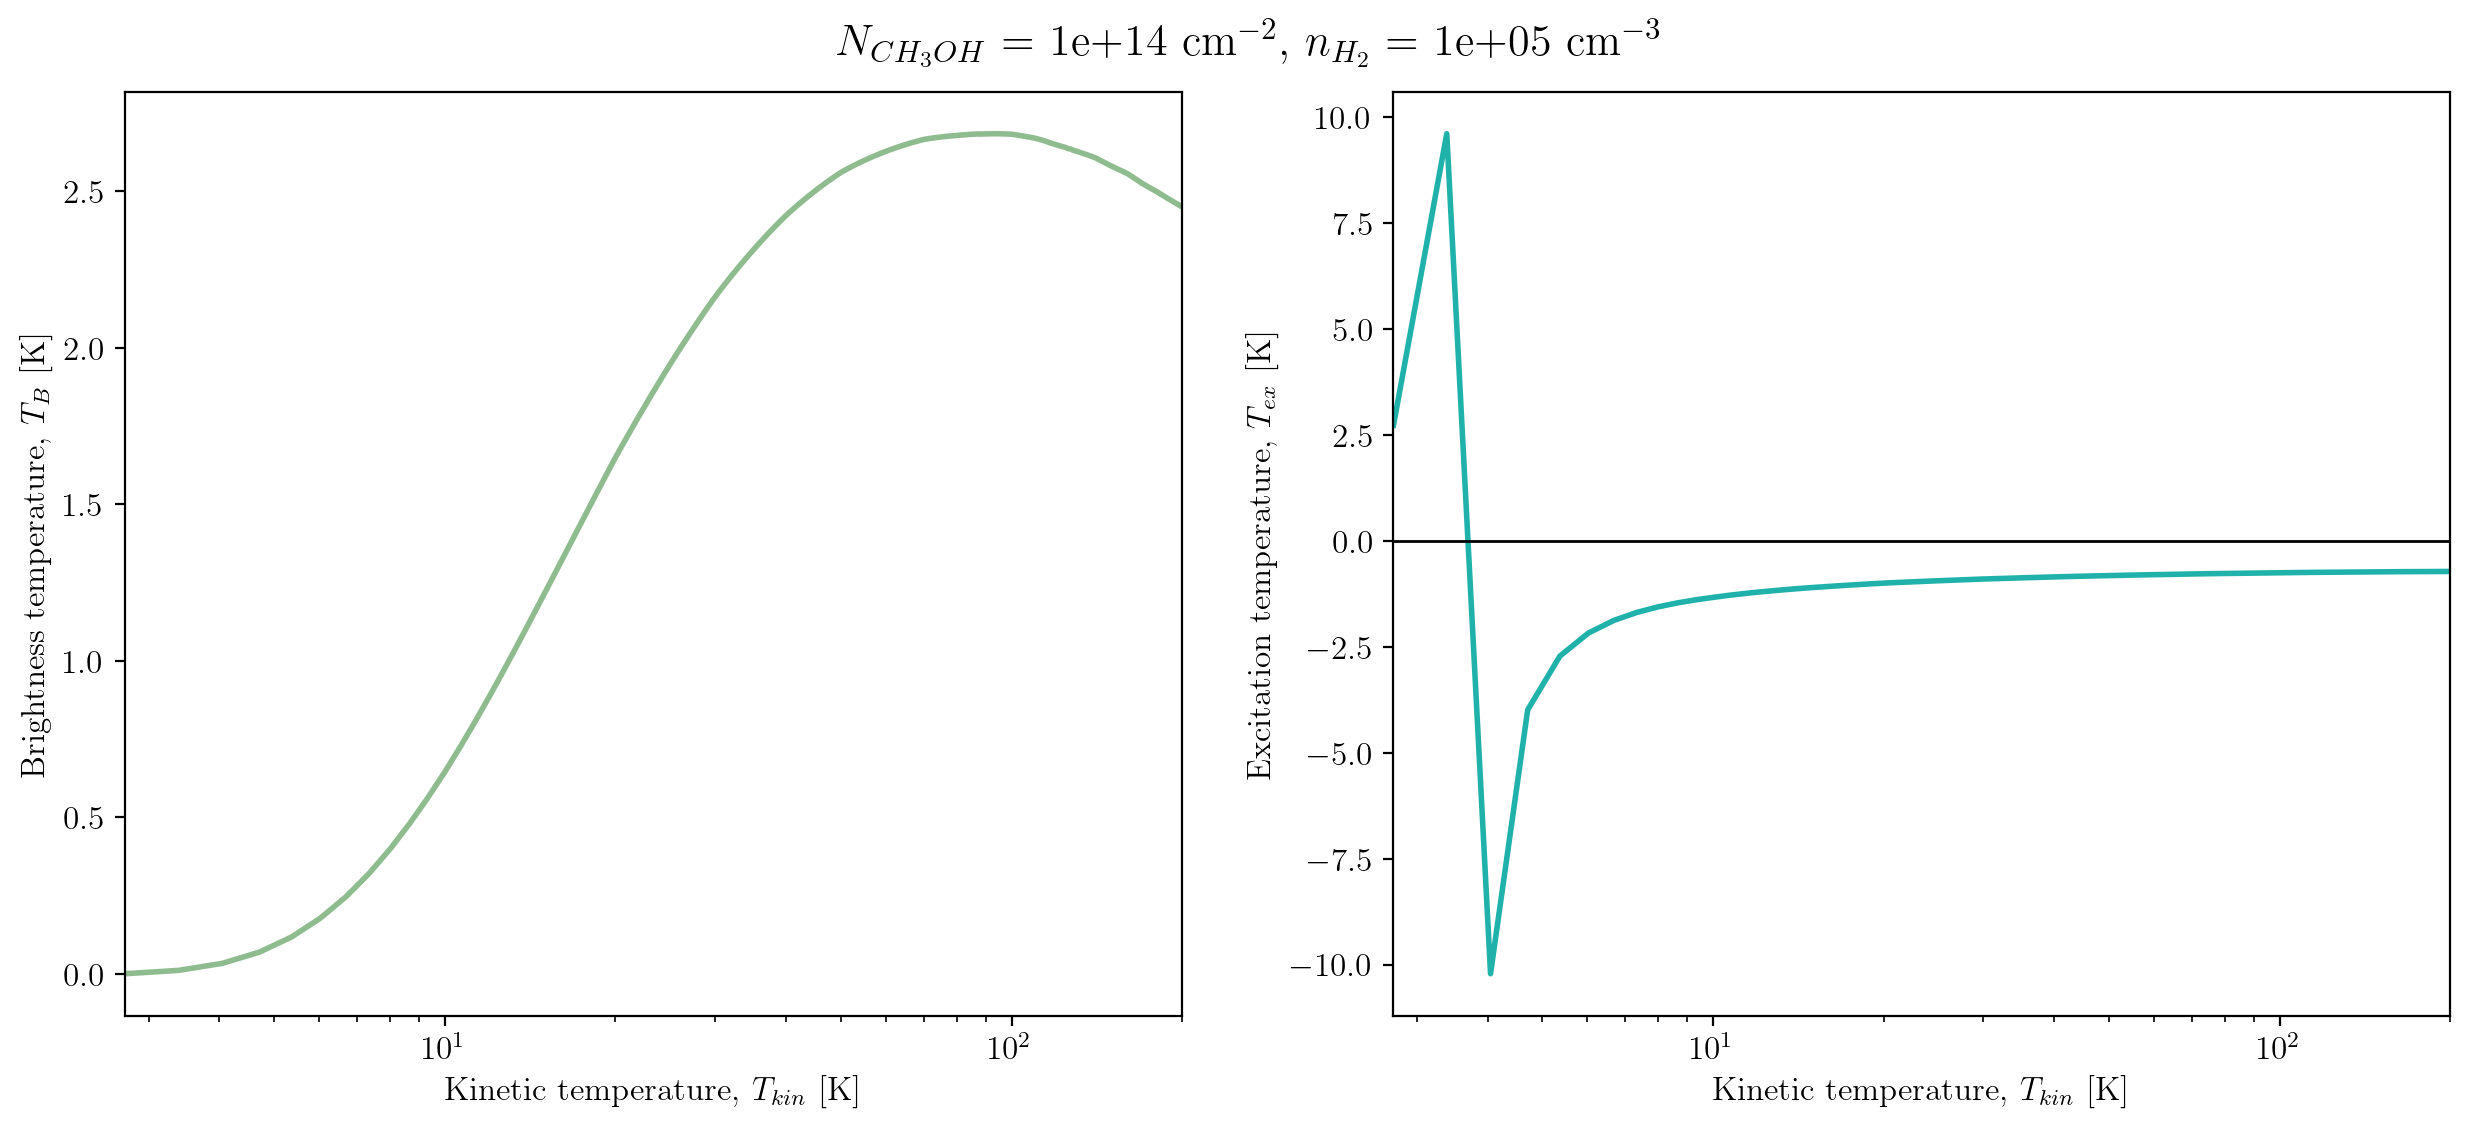

In [26]:
tex3 = [r['Tex'] for r in rslts3]
tau3 = [r['tau'] for r in rslts3]
T_B3 = [r['T_B'] for r in rslts3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), dpi = 200)
ax1.semilogx(temps, T_B3, color = 'darkseagreen', linewidth = 2)
ax1.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax1.set_ylabel("Brightness temperature, $T_{B}$ [K]")
ax1.set_xlim(min(temps), max(temps))

ax2.semilogx(temps, tex3, color = 'lightseagreen', linewidth = 2)
ax2.axhline(0, color = 'k', linewidth = 1)
ax2.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax2.set_ylabel("Excitation temperature, $T_{ex}$ [K]")
ax2.set_xlim(min(temps), max(temps))

plt.suptitle(f"$N_{{CH_3 OH}}$ = {set_column:.0e} cm$^{{-2}}$, $n_{{H_2}}$ = {set_density:.0e} cm$^{{-3}}$", y = 0.94)

In [27]:
# Now just explore density and column density
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[35]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:1056: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


In [28]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

-2343.954358479339 is the minimum, it doesn't actually go down to -1


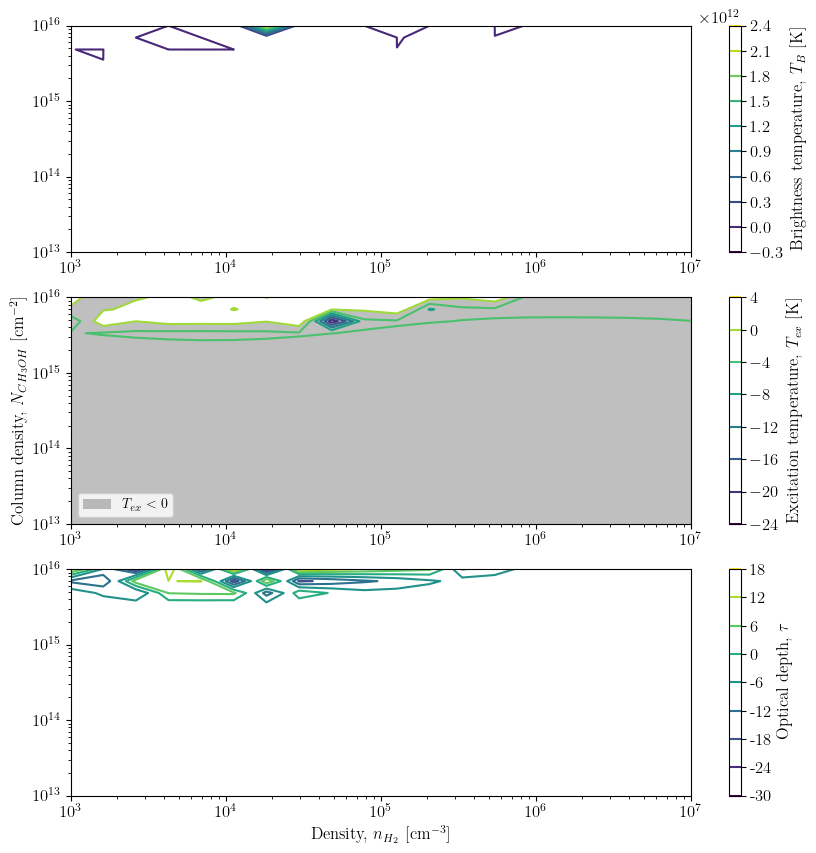

In [29]:
import matplotlib.colors as colors

the_best_colormap = 'viridis'

radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

# radex_tb_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tb_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_T_B)
# radex_tex_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tex_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tex)
# radex_tau_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tau_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tau)

lvl_set = 11 # odd, want smth at middle

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 10)) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  # levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

cp2 = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, 
                  # levels = np.around(np.linspace(np.min(radex_tex)*0.9, 2.73, 19), decimals = 2), 
                  cmap = the_best_colormap, alpha = 1) #magma
ax2.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")

# Shade where T_ex goes below 0 (inversion)
cs2 = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex, 
                   levels = [np.min(radex_tex), 0.0],
                   alpha = 0.5, colors = ['grey'])
artists2, labels2 = cs2.legend_elements()
ax2.legend(handles = [artists2[0]], labels = ['$T_{ex} < 0$'], loc="lower left")

cp3 = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, 
                  # levels = lvl_set, 
                  cmap = the_best_colormap, alpha = 1, #viridis
                  # norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max())
                 )
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
cb3 = plt.colorbar(cp3, ax = ax3, extend = 'max', label = r"Optical depth, $\tau$")
cb3.set_ticklabels([f'{x:0.1g}' if x % 1 > 0 else int(x) for x in cb3.get_ticks()])

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# plt.suptitle("RADEX")

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_36GHz.pdf', bbox_inches = 'tight')
# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_36GHz.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### Do the same for the 108.9 GHz line too!!

In [30]:
# Which line is the 108.9 GHz line?
np.argmax((tbl['upperlevel'] == b'0_0   ') & (tbl['lowerlevel'] == b'1_-1  '))

108

In [31]:
tbl[108] # DAMN that is weird

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
3.496526081412499,0.3362808377842323,108.893945,13.1,0_0,1_-1,0.00847695751763557,0.1133511894803869,6.309023340215297e-16,0.1731740437752802


In [ ]:
# Quickly explore as a function of temperature
temps = np.linspace(2.73, 200, 100)
rslts3 = [rr(temperature=temp, density={'H2':set_density}, column=set_column)[108]['Tex', 'tau', 'T_B'] for temp in temps]

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "


/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:1056: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


In [ ]:
tex3 = [r['Tex'] for r in rslts3]
tau3 = [r['tau'] for r in rslts3]
T_B3 = [r['T_B'] for r in rslts3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), dpi = 200)
ax1.semilogx(temps, T_B3, color = 'darkseagreen', linewidth = 2)
ax1.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax1.set_ylabel("Brightness temperature, $T_{B}$ [K]")
ax1.set_xlim(min(temps), max(temps))

ax2.semilogx(temps, tex3, color = 'lightseagreen', linewidth = 2)
ax2.axhline(0, color = 'k', linewidth = 1)
ax2.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax2.set_ylabel("Excitation temperature, $T_{ex}$ [K]")
ax2.set_xlim(min(temps), max(temps))

plt.suptitle(f"$N_{{CH_3 OH}}$ = {set_column:.0e} cm$^{{-2}}$, $n_{{H_2}}$ = {set_density:.0e} cm$^{{-3}}$", y = 0.94)

In [ ]:
# Now just explore density and column density
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[108]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

In [ ]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

In [ ]:
import matplotlib.colors as colors

the_best_colormap = 'viridis'

radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

# radex_tb_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tb_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_T_B)
# radex_tex_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tex_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tex)
# radex_tau_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tau_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tau)

lvl_set = 11 # odd, want smth at middle

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 10)) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  # levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

cp2 = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, 
                  # levels = np.around(np.linspace(np.min(radex_tex)*0.9, 2.73, 19), decimals = 2), 
                  cmap = the_best_colormap, alpha = 1) #magma
ax2.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")

# Shade where T_ex goes below 0 (inversion)
# cs2 = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex, 
#                    # levels = [np.min(radex_tex), 0.0],
#                    alpha = 0.5, colors = ['grey'])
# artists2, labels2 = cs2.legend_elements()
# ax2.legend(handles = [artists2[0]], labels = ['$T_{ex} < 0$'], loc="lower left")

cp3 = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, 
                  # levels = lvl_set, 
                  cmap = the_best_colormap, alpha = 1, #viridis
                  # norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max())
                 )
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
cb3 = plt.colorbar(cp3, ax = ax3, extend = 'max', label = r"Optical depth, $\tau$")
cb3.set_ticklabels([f'{x:0.1g}' if x % 1 > 0 else int(x) for x in cb3.get_ticks()])

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# plt.suptitle("RADEX")

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_108p9GHz.pdf', bbox_inches = 'tight')
# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_108p9GHz.png', dpi = 200, bbox_inches = 'tight')
plt.show()

## Now let's make a brightness temperature plot for the other dasars

### ~157 GHz

In [ ]:
ls /orange/adamginsburg/repos/pyradex/lamda/

In [ ]:
# Get methanol A species results for given column, density, and temperature
set_column = 1e14
set_density = 1e5
set_temp = 50
rr = pyradex.Radex(species='ch3oh_a', column=set_column, density=set_density, temperature=set_temp)
tbl = rr()

In [ ]:
# Which line is the dasar line?
np.argmax((tbl['upperlevel'] == b'2_1   ') & (tbl['lowerlevel'] == b'3_0   '))

In [ ]:
tbl[81]

In [ ]:
# Quickly explore as a function of temperature
temps = np.linspace(2.73, 200, 300)
rslts3 = [rr(temperature=temp, density={'H2':set_density}, column=set_column)[81]['Tex', 'tau', 'T_B'] for temp in temps]

In [ ]:
tex3 = [r['Tex'] for r in rslts3]
tau3 = [r['tau'] for r in rslts3]
T_B3 = [r['T_B'] for r in rslts3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), dpi = 200)
ax1.semilogx(temps, T_B3, color = 'darkseagreen', linewidth = 2)
ax1.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax1.set_ylabel("Brightness temperature, $T_{B}$ [K]")
ax1.set_xlim(min(temps), max(temps))

ax2.semilogx(temps, tex3, color = 'lightseagreen', linewidth = 2)
ax2.axhline(0, color = 'k', linewidth = 1)
ax2.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax2.set_ylabel("Excitation temperature, $T_{ex}$ [K]")
ax2.set_xlim(min(temps), max(temps))

plt.suptitle(f"$N_{{CH_3 OH}}$ = {set_column:.0e} cm$^{{-2}}$, $n_{{H_2}}$ = {set_density:.0e} cm$^{{-3}}$", y = 0.94)

In [ ]:
# Now just explore density and column density
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[81]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

In [ ]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

In [ ]:
import matplotlib

In [ ]:
radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

lvl_set = 11 # odd, want smth at middle

fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4), dpi = 200) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

### Brightness temperature plot
cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

# Shading where T_B goes below 0, and where it goes below our data value (-0.03 K is placeholder for now)
# darkest_spectrum = -0.57
# least_dark_spectrum_detectable = -0.03 # This is negative 1 sigma
# radex_T_B_arr = np.array(radex_T_B)
# [c, d] = np.where((radex_T_B_arr > darkest_spectrum) & (radex_T_B_arr < least_dark_spectrum_detectable))

# radex_T_B_arr_hatch = np.zeros(radex_T_B_arr.shape)
# radex_T_B_arr_hatch[c, d] = 1

# Putting contours at the points where the minimum values of spectral extractions are
# So, that is at -0.046 K and -0.117 K
# minimum_of_cavity_wall_meanspec = -0.046
# minimum_of_cavity_wall_meanspec_5sigma = -0.117

# cs1 = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [darkest_spectrum, least_dark_spectrum_detectable],
#                    alpha = 0.5, colors = ['grey'])
# cs1a = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec], alpha = 1, colors = ['b'])
# cs1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec_5sigma], alpha = 1, colors = ['r'], linestyles = ['-.'])
# artists1, labels1 = cs1.legend_elements()
# artists1a, labels1a = cs1a.legend_elements()
# artists1b, labels1b = cs1b.legend_elements()
# ax1.legend(fontsize = 10, handles = [artists1[0], artists1a[0], artists1b[0]], 
#            labels = [f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K', 
#                      f'$T_B = {minimum_of_cavity_wall_meanspec}$ K',
#                      f'$T_B = {minimum_of_cavity_wall_meanspec_5sigma}$ K'], loc="upper right")

# Put a cross where we sampled for the temperature figure
# temp_marker_size = 80
# ax1.scatter(1e5, 1e14, marker = "+", c='k', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e5, 1e15, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e5, 1e13, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e4, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e6, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e4, 1e15, marker = "+", c='teal', s=temp_marker_size, zorder = 100)

# Put a circle at the minimum
radex_T_B = np.array(radex_T_B)
radex_T_B_2D = radex_T_B.reshape(radex_T_B.shape[0]*radex_T_B.shape[1])
row, col = np.unravel_index(np.argmin(radex_T_B_2D), radex_T_B.shape)
density = radex_dens_grid[row, col]
coldens = radex_coldens_grid[row, col]

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-1, vmax=0)
ax1.scatter(density, coldens, marker = "o",  c=cmap(norm(np.min(radex_T_B))), s=80, zorder = 100, label = f"$T_{{B_{{min}}}} = {np.min(radex_T_B):.2g}$ K")

ax1.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
ax1.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")

ax1.legend()

for ax in [ax1]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.grid(alpha = 0.5)
    
# Make sure plot backgrounds are right for poster
ax1.set(facecolor = "white")
fig.patch.set_alpha(0.0)

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_157GHz.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### ~206 GHz

In [ ]:
ls /orange/adamginsburg/repos/pyradex/lamda/

In [ ]:
# Get methanol A species results for given column, density, and temperature
set_column = 1e14
set_density = 1e5
set_temp = 50
rr = pyradex.Radex(species='ch3oh_a', column=set_column, density=set_density, temperature=set_temp)
tbl = rr()

In [ ]:
# Which line is the dasar line?
np.argmax((tbl['upperlevel'] == b'1_1   ') & (tbl['lowerlevel'] == b'2_0   '))

In [ ]:
tbl[103]

In [ ]:
# Quickly explore as a function of temperature
temps = np.linspace(2.73, 200, 300)
rslts3 = [rr(temperature=temp, density={'H2':set_density}, column=set_column)[103]['Tex', 'tau', 'T_B'] for temp in temps]

In [ ]:
tex3 = [r['Tex'] for r in rslts3]
tau3 = [r['tau'] for r in rslts3]
T_B3 = [r['T_B'] for r in rslts3]

fig, ax1 = plt.subplots(1, 1, figsize = (6, 5), dpi = 200) # ax2
ax1.semilogx(temps, T_B3, color = 'darkseagreen', linewidth = 2)
ax1.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
ax1.set_ylabel("Brightness temperature, $T_{B}$ [K]")
ax1.set_xlim(min(temps), max(temps))

# ax2.semilogx(temps, tex3, color = 'lightseagreen', linewidth = 2)
# ax2.axhline(0, color = 'k', linewidth = 1)
# ax2.set_xlabel("Kinetic temperature, $T_{kin}$ [K]")
# ax2.set_ylabel("Excitation temperature, $T_{ex}$ [K]")
# ax2.set_xlim(min(temps), max(temps))

ylim1 = ax1.get_ylim()
xlim1 = ax1.get_xlim()
ylim2 = ax2.get_ylim()
xlim2 = ax2.get_xlim()

ax1.axhline(0, color = 'black', linewidth = 1)
# Modeling occurs at 100K
ax1.plot((100, 100), (-0.03, -0.01), color = 'k', linestyle = (0, (5, 1)), linewidth = 1)

ax1.set_ylim(ylim1)
ax1.set_xlim(xlim1)
ax2.set_ylim(ylim2)
ax2.set_xlim(xlim2)

plt.suptitle(f"$N_{{CH_3 OH}}$ = {set_column:.0e} cm$^{{-2}}$, $n_{{H_2}}$ = {set_density:.0e} cm$^{{-3}}$", y = 0.95)

# Make sure plot backgrounds are right for poster
ax1.set(facecolor = "white")
fig.patch.set_alpha(0.0)

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_206GHz_not_dasing.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [ ]:
# Now just explore density and column density
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[103]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

In [ ]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

In [ ]:
import matplotlib

In [ ]:
radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

lvl_set = 11 # odd, want smth at middle

fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4), dpi = 200) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

### Brightness temperature plot
cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  levels = np.linspace(-1, 0, lvl_set), 
                  cmap = the_best_colormap, alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

# Shading where T_B goes below 0, and where it goes below our data value (-0.03 K is placeholder for now)
# darkest_spectrum = -0.57
# least_dark_spectrum_detectable = -0.03 # This is negative 1 sigma
# radex_T_B_arr = np.array(radex_T_B)
# [c, d] = np.where((radex_T_B_arr > darkest_spectrum) & (radex_T_B_arr < least_dark_spectrum_detectable))

# radex_T_B_arr_hatch = np.zeros(radex_T_B_arr.shape)
# radex_T_B_arr_hatch[c, d] = 1

# Putting contours at the points where the minimum values of spectral extractions are
# So, that is at -0.046 K and -0.117 K
# minimum_of_cavity_wall_meanspec = -0.046
# minimum_of_cavity_wall_meanspec_5sigma = -0.117

# cs1 = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [darkest_spectrum, least_dark_spectrum_detectable],
#                    alpha = 0.5, colors = ['grey'])
# cs1a = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec], alpha = 1, colors = ['b'])
# cs1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [minimum_of_cavity_wall_meanspec_5sigma], alpha = 1, colors = ['r'], linestyles = ['-.'])
# artists1, labels1 = cs1.legend_elements()
# artists1a, labels1a = cs1a.legend_elements()
# artists1b, labels1b = cs1b.legend_elements()
# ax1.legend(fontsize = 10, handles = [artists1[0], artists1a[0], artists1b[0]], 
#            labels = [f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K', 
#                      f'$T_B = {minimum_of_cavity_wall_meanspec}$ K',
#                      f'$T_B = {minimum_of_cavity_wall_meanspec_5sigma}$ K'], loc="upper right")

# Put a cross where we sampled for the temperature figure
# temp_marker_size = 80
# ax1.scatter(1e5, 1e14, marker = "+", c='k', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e5, 1e15, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e5, 1e13, marker = "+", c='orange', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e4, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e6, 1e14, marker = "+", c='mediumorchid', s=temp_marker_size, zorder = 100)
# ax1.scatter(1e4, 1e15, marker = "+", c='teal', s=temp_marker_size, zorder = 100)

# Put a circle at the minimum
radex_T_B = np.array(radex_T_B)
radex_T_B_2D = radex_T_B.reshape(radex_T_B.shape[0]*radex_T_B.shape[1])
row, col = np.unravel_index(np.argmin(radex_T_B_2D), radex_T_B.shape)
density = radex_dens_grid[row, col]
coldens = radex_coldens_grid[row, col]

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-1, vmax=0)
ax1.scatter(density, coldens, marker = "o",  c=cmap(norm(np.min(radex_T_B))), s=80, zorder = 100, label = f"$T_{{B_{{min}}}} = {np.min(radex_T_B):.2g}$ K")

ax1.set_ylabel("Column density, $N_{CH_3 OH}$ [cm$^{-2}$]")
ax1.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")

ax1.legend()

for ax in [ax1]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.grid(alpha = 0.5)
    
# Make sure plot backgrounds are right for poster
ax1.set(facecolor = "white")
fig.patch.set_alpha(0.0)

# plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results_206GHz.png', dpi = 200, bbox_inches = 'tight')
plt.show()